In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.testing import SeqIndTester
import matplotlib
from tqdm import tqdm
import matplotlib_inline

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "CMU Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["axes.axisbelow"] = True

In [ ]:
timeseries_length = 10000
num_streams = 50

e_detector_cusum = np.zeros((num_streams, timeseries_length + 1))
e_detector_sr = np.zeros((num_streams, timeseries_length + 1))

# generate sphere data
X = np.random.normal(size=(num_streams, timeseries_length, 1))
X[:, 200:, :] += 2

for t in tqdm(range(timeseries_length)):
    for k in range(num_streams):
        likelihood_ratio = np.exp(-0.5 * ((X[k, t] - 1) ** 2 - (X[k, t] + 1) ** 2))
        e_detector_cusum[k, t + 1] = likelihood_ratio * max(e_detector_cusum[k, t], 1)
        e_detector_sr[k, t + 1] = likelihood_ratio * (e_detector_sr[k, t] + 1)

100%|██████████| 10000/10000 [00:02<00:00, 4205.02it/s]


In [ ]:
n_sims = 100
alpha = 0.001
timeseries_length = 10000
num_streams = 50

fdp = np.zeros((n_sims, timeseries_length))

for n in tqdm(range(n_sims)):
    X = np.random.normal(size=(num_streams, timeseries_length))
    e_detector_cusum = np.zeros((num_streams, timeseries_length + 1))

    for t in range(timeseries_length):
        if fdp[n, t] != 1:
            for k in range(num_streams):
                likelihood_ratio = np.exp(-0.5 * ((X[k, t] - 1) ** 2 - X[k, t] ** 2))
                e_detector_cusum[k, t + 1] = likelihood_ratio * max(
                    e_detector_cusum[k, t], 1
                )
                
                
                if e_detector_cusum[k, t + 1] >= 1 / alpha:
                    fdp[n, t:] = 1

100%|██████████| 100/100 [00:01<00:00, 56.25it/s]


In [ ]:
fdr = np.mean(fdp, axis=0)
plt.plot(fdr)

plt.xlabel("Time")
plt.ylabel("FDR")
plt.title("Naive FDR control")

plt.show()

In [123]:
n_sims = 100
alpha = 0.001
timeseries_length = 10000
num_streams = 50

fdp = np.zeros((n_sims, timeseries_length))

for n in tqdm(range(n_sims)):
    X = np.random.normal(size=(num_streams, timeseries_length))
    e_detector_cusum = np.zeros((num_streams, timeseries_length + 1))

    for t in range(timeseries_length):
        if fdp[n, t] != 1:
            for k in range(num_streams):
                likelihood_ratio = np.exp(-0.5 * ((X[k, t] - 1) ** 2 - X[k, t] ** 2))
                e_detector_cusum[k, t + 1] = likelihood_ratio * max(
                    e_detector_cusum[k, t], 1
                )

            order_statistics = sorted(
                zip(e_detector_cusum[:, t+1], range(num_streams)), key=lambda x: -x[0]
            )

            k_star = max(
                (
                    k
                    for k in range(num_streams + 1)
                    if all(
                        order_statistics[i][0] / (num_streams - i) >= 1 / alpha
                        for i in range(k)
                    )
                ),
                default=0,
            )

            if k_star > 0:
                fdp[n, t:] = 1

100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


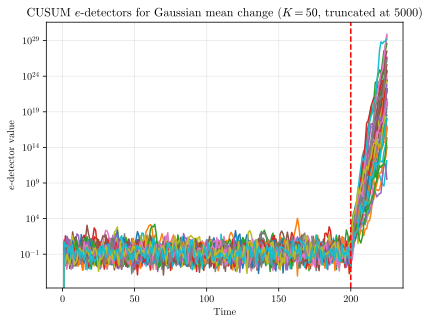

In [5]:
plt.plot(e_detector_cusum.T)

plt.xlabel("Time")
plt.ylabel("$e$-detector value")

plt.title("CUSUM $e$-detectors for Gaussian mean change ($K = 50$, truncated at 5000)")

plt.axvline(200, color="red", linestyle="--")

plt.yscale("log")

plt.grid(alpha=0.3)
plt.savefig("e-detectors-cusum.png", bbox_inches="tight")

plt.show()

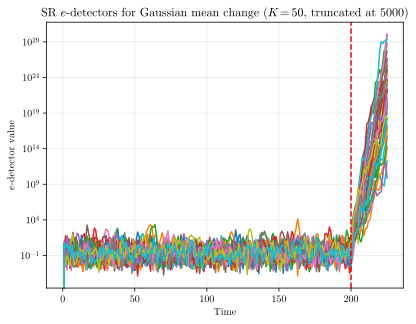

In [6]:
plt.plot(e_detector_sr.T)

plt.xlabel("Time")
plt.ylabel("$e$-detector value")

plt.title("SR $e$-detectors for Gaussian mean change ($K = 50$, truncated at 5000)")

plt.axvline(200, color="red", linestyle="--")

plt.yscale("log")

plt.grid(alpha=0.3)
plt.savefig("e-detectors-sr.png", bbox_inches="tight")

plt.show()

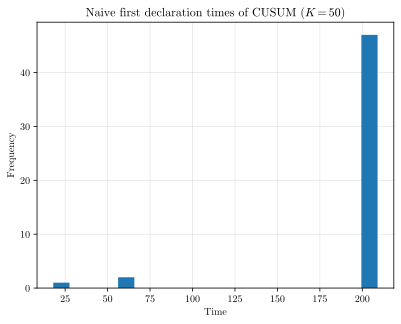

In [ ]:
first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    for k in range(num_streams):
        if first_rejection_times[k] == 0 and e_detector_cusum[k, t] >= 1000:
            first_rejection_times[k] = t + 1

plt.hist(first_rejection_times, bins=20)

plt.xlabel("Time")
plt.ylabel("Frequency")

plt.title("Naive first declaration times of CUSUM ($K = 50$)")

plt.grid(alpha=0.3)

plt.savefig("naive-cusum.png", bbox_inches="tight")

plt.show()

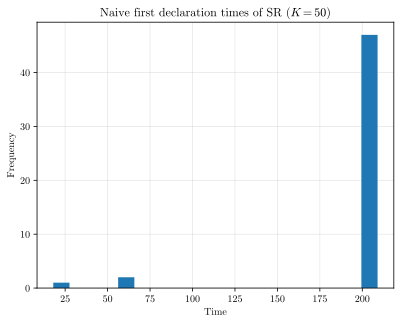

In [ ]:
first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    for k in range(num_streams):
        if first_rejection_times[k] == 0 and e_detector_sr[k, t] >= 1000:
            first_rejection_times[k] = t + 1

plt.hist(first_rejection_times, bins=20)

plt.xlabel("Time")
plt.ylabel("Frequency")

plt.title("Naive first declaration times of SR ($K = 50$)")

plt.grid(alpha=0.3)

plt.savefig("naive-sr.png", bbox_inches="tight")

plt.show()

In [ ]:
np.count_nonzero(first_rejection_times < 200)

50

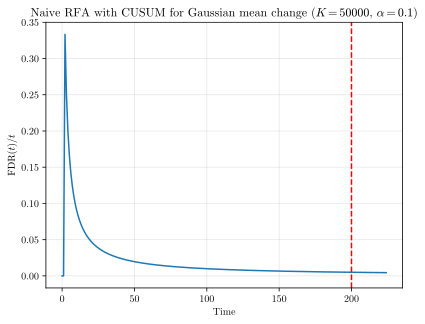

In [ ]:
fdr = np.zeros(timeseries_length)
for t in range(200):
    fdr[t] = np.sum(first_rejection_times <= t) > 0

for t in range(200, timeseries_length):
    fdr[t] = np.sum(first_rejection_times <= 199) / np.sum(first_rejection_times <= t)


plt.plot(fdr / np.arange(1, timeseries_length + 1))

plt.xlabel("Time")
plt.ylabel("$\mathrm{FDR}(t) / t$")
plt.title(
    "Naive RFA with CUSUM for Gaussian mean change ($K = 50000$, $\\alpha = 0.1$)"
)

plt.grid(alpha=0.3)
plt.axvline(200, color="red", linestyle="--")

plt.savefig("rfa-cusum-naive.png", bbox_inches="tight")

plt.show()

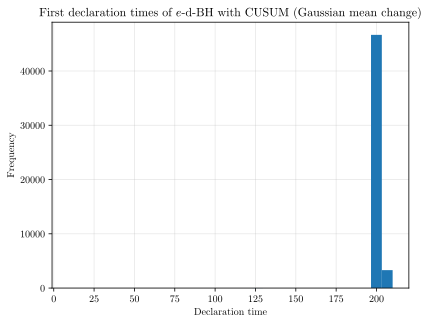

In [ ]:
alpha = 0.5

first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    order_statistics = sorted(
        zip(e_detector_cusum[:, t], range(num_streams)), key=lambda x: -x[0]
    )

    k_star = max(
        (
            k + 1
            for k in range(num_streams)
            if (k + 1) * order_statistics[k][0] / num_streams >= 1 / alpha
        ),
        default=0,
    )

    for i in range(k_star):
        if first_rejection_times[order_statistics[i][1]] == 0:
            first_rejection_times[order_statistics[i][1]] = t + 1

plt.hist(first_rejection_times, bins=30)
plt.xlabel("Declaration time")
plt.ylabel("Frequency")

plt.title("First declaration times of $e$-d-BH with CUSUM (Gaussian mean change)")
plt.grid(alpha=0.3)

plt.savefig("edbh-cusum.png", bbox_inches="tight")

plt.show()

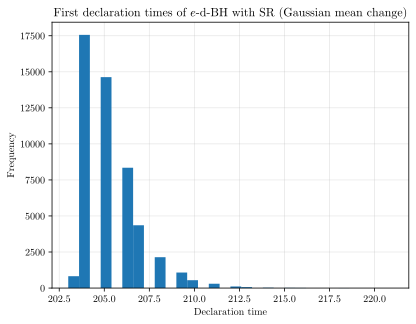

In [ ]:
alpha = 0.001

first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    order_statistics = sorted(
        zip(e_detector_sr[:, t], range(num_streams)), key=lambda x: -x[0]
    )

    k_star = max(
        (
            k + 1
            for k in range(num_streams)
            if (k + 1) * order_statistics[k][0] / num_streams >= 1 / alpha
        ),
        default=0,
    )

    for i in range(k_star):
        if first_rejection_times[order_statistics[i][1]] == 0:
            first_rejection_times[order_statistics[i][1]] = t + 1

plt.hist(first_rejection_times, bins=30)
plt.xlabel("Declaration time")
plt.ylabel("Frequency")

plt.title("First declaration times of $e$-d-BH with SR (Gaussian mean change)")
plt.grid(alpha=0.3)

plt.savefig("edbh-sr-50k.png", bbox_inches="tight")

plt.show()

In [ ]:
np.count_nonzero(first_rejection_times < 200)

31

/var/folders/43/sfdz93_d3h330ysq5n42ylq00000gn/T/ipykernel_37745/1655664981.py:6: RuntimeWarning: invalid value encountered in scalar divide
  fdr[t] = np.sum(first_rejection_times <= 199) / np.sum(first_rejection_times <= t)


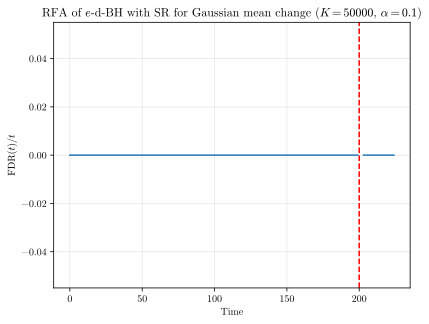

In [ ]:
fdr = np.zeros(timeseries_length)
for t in range(200):
    fdr[t] = np.sum(first_rejection_times <= t) > 0

for t in range(200, timeseries_length):
    fdr[t] = np.sum(first_rejection_times <= 199) / np.sum(first_rejection_times <= t)


plt.plot(fdr / np.arange(1, timeseries_length + 1))

plt.xlabel("Time")
plt.ylabel("$\mathrm{FDR}(t) / t$")
plt.title("RFA of $e$-d-BH with SR for Gaussian mean change ($K = 50000$, $\\alpha = 0.1$)")

plt.grid(alpha=0.3)
plt.axvline(200, color="red", linestyle="--")

plt.savefig("rfa-sr.png", bbox_inches="tight")

plt.show()

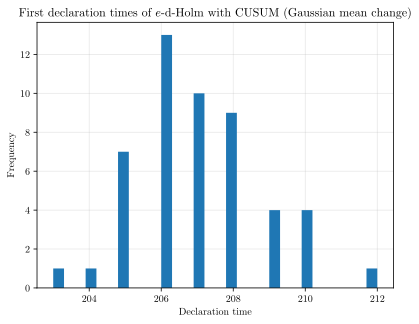

In [ ]:
alpha = 0.001

first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    order_statistics = sorted(
        zip(e_detector_cusum[:, t], range(num_streams)), key=lambda x: -x[0]
    )

    k_star = max(
        (
            k
            for k in range(num_streams + 1)
            if all(
                order_statistics[i][0] / (num_streams - i) >= 1 / alpha
                for i in range(k)
            )
        ),
        default=0,
    )

    for i in range(k_star):
        if first_rejection_times[order_statistics[i][1]] == 0:
            first_rejection_times[order_statistics[i][1]] = t + 1

plt.hist(first_rejection_times, bins=30)
plt.xlabel("Declaration time")
plt.ylabel("Frequency")

plt.title("First declaration times of $e$-d-Holm with CUSUM (Gaussian mean change)")
plt.grid(alpha=0.3)

plt.savefig("edholm-cusum.png", bbox_inches="tight")

plt.show()

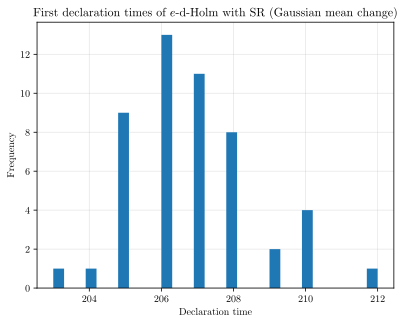

In [ ]:
alpha = 0.001

first_rejection_times = np.zeros(num_streams)
for t in range(timeseries_length):
    order_statistics = sorted(
        zip(e_detector_sr[:, t], range(num_streams)), key=lambda x: -x[0]
    )

    k_star = max(
        (
            k
            for k in range(num_streams + 1)
            if all(
                order_statistics[i][0] / (num_streams - i) >= 1 / alpha
                for i in range(k)
            )
        ),
        default=0,
    )

    for i in range(k_star):
        if first_rejection_times[order_statistics[i][1]] == 0:
            first_rejection_times[order_statistics[i][1]] = t + 1

plt.hist(first_rejection_times, bins=30)
plt.xlabel("Declaration time")
plt.ylabel("Frequency")

plt.title("First declaration times of $e$-d-Holm with SR (Gaussian mean change)")
plt.grid(alpha=0.3)

plt.savefig("edholm-sr.png", bbox_inches="tight")

plt.show()

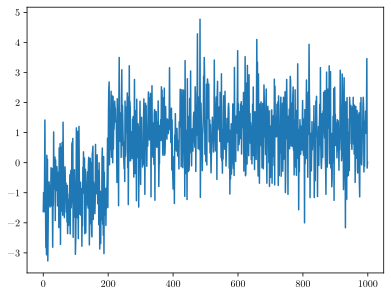

In [55]:
plt.plot(X[-1, :])